# Custom models with PyTorch

This notebook illustrates how one can implement a time series model in GluonTS using PyTorch, train it with PyTorch Lightning, and use it together with the rest of the GluonTS ecosystem for data loading, feature processing, and model evaluation.

In [1]:
from typing import List, Optional, Callable, Iterable
from itertools import islice

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

For this example we will use the "electricity" dataset, which can be loaded as follows.

In [3]:
from gluonts.dataset.repository import get_dataset

In [4]:
dataset = get_dataset("electricity")

This is what the first time series from the training portion of the dataset look like:

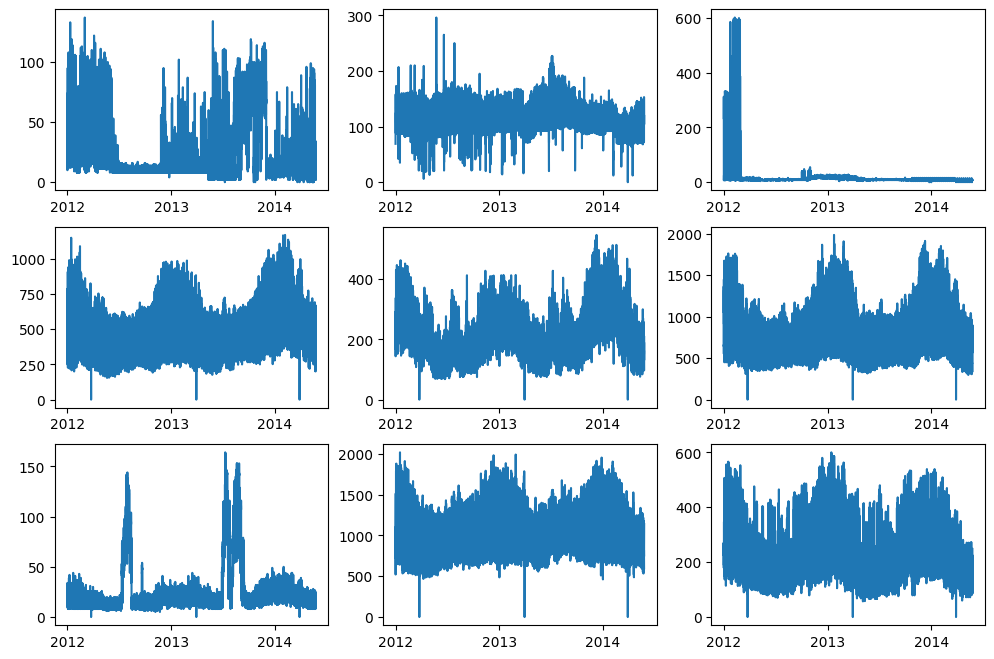

In [5]:
date_formater = mdates.DateFormatter("%Y")

fig = plt.figure(figsize=(12, 8))
for idx, entry in enumerate(islice(dataset.train, 9)):
    ax = plt.subplot(3, 3, idx + 1)
    t = pd.date_range(
        start=entry["start"].to_timestamp(),
        periods=len(entry["target"]),
        freq=entry["start"].freq,
    )
    plt.plot(t, entry["target"])
    plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))
    ax.xaxis.set_major_formatter(date_formater)

## Probabilistic feed-forward network using PyTorch

We will use a pretty simple model, based on a feed-forward network whose output layer produces the parameters of a parametric distribution. By default, the model will use a Student's t-distribution, but this can be easily customized via the `distr_output` constructor argument.

In [6]:
import torch
import torch.nn as nn

In [7]:
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import StudentTOutput
from gluonts.model.forecast_generator import DistributionForecastGenerator

In [8]:
def mean_abs_scaling(context, min_scale=1e-5):
    return context.abs().mean(1).clamp(min_scale, None).unsqueeze(1)

In [9]:
class FeedForwardNetwork(nn.Module):
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        hidden_dimensions: List[int],
        distr_output=StudentTOutput(),
        batch_norm: bool = False,
        scaling: Callable = mean_abs_scaling,
    ) -> None:
        super().__init__()

        assert prediction_length > 0
        assert context_length > 0
        assert len(hidden_dimensions) > 0

        self.prediction_length = prediction_length
        self.context_length = context_length
        self.hidden_dimensions = hidden_dimensions
        self.distr_output = distr_output
        self.batch_norm = batch_norm
        self.scaling = scaling

        dimensions = [context_length] + hidden_dimensions[:-1]

        modules = []
        for in_size, out_size in zip(dimensions[:-1], dimensions[1:]):
            modules += [self.__make_lin(in_size, out_size), nn.ReLU()]
            if batch_norm:
                modules.append(nn.BatchNorm1d(out_size))
        modules.append(
            self.__make_lin(dimensions[-1], prediction_length * hidden_dimensions[-1])
        )

        self.nn = nn.Sequential(*modules)
        self.args_proj = self.distr_output.get_args_proj(hidden_dimensions[-1])

    @staticmethod
    def __make_lin(dim_in, dim_out):
        lin = nn.Linear(dim_in, dim_out)
        torch.nn.init.uniform_(lin.weight, -0.07, 0.07)
        torch.nn.init.zeros_(lin.bias)
        return lin

    def forward(self, past_target):
        scale = self.scaling(past_target)
        scaled_past_target = past_target / scale
        nn_out = self.nn(scaled_past_target)
        nn_out_reshaped = nn_out.reshape(
            -1, self.prediction_length, self.hidden_dimensions[-1]
        )
        distr_args = self.args_proj(nn_out_reshaped)
        return distr_args, torch.zeros_like(scale), scale

    def get_predictor(self, input_transform, batch_size=32):
        return PyTorchPredictor(
            prediction_length=self.prediction_length,
            input_names=["past_target"],
            prediction_net=self,
            batch_size=batch_size,
            input_transform=input_transform,
            forecast_generator=DistributionForecastGenerator(self.distr_output),
        )

To train the model using PyTorch Lightning, we only need to extend the class with methods that specify how training steps are supposed to work. Please refer to [documentation for PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) to know more about the interface you need to implement in order to fully customize the training procedure.

In [10]:
import lightning.pytorch as pl

In [11]:
class LightningFeedForwardNetwork(FeedForwardNetwork, pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        past_target = batch["past_target"]
        future_target = batch["future_target"]

        assert past_target.shape[-1] == self.context_length
        assert future_target.shape[-1] == self.prediction_length

        distr_args, loc, scale = self(past_target)
        distr = self.distr_output.distribution(distr_args, loc, scale)
        loss = -distr.log_prob(future_target)

        return loss.mean()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

We can now instantiate the training network, and explore its set of parameters.

In [12]:
context_length = 2 * 7 * 24
prediction_length = dataset.metadata.prediction_length
hidden_dimensions = [96, 48]

In [13]:
net = LightningFeedForwardNetwork(
    prediction_length=prediction_length,
    context_length=context_length,
    hidden_dimensions=hidden_dimensions,
    distr_output=StudentTOutput(),
)

In [14]:
sum(np.prod(p.shape) for p in net.parameters())

144243

In [15]:
for p in net.parameters():
    print(p.shape)

torch.Size([96, 336])
torch.Size([96])
torch.Size([1152, 96])
torch.Size([1152])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])


## Defining the training data loader

We now set up the data loader which will yield batches of data to train on. Starting from the original dataset, the data loader is configured to apply the following transformation, which does essentially two things:
* Replaces `nan`s in the target field with a dummy value (zero), and adds a field indicating which values were actually observed vs imputed this way.
* Slices out training instances of a fixed length randomly from the given dataset; these will be stacked into batches by the data loader itself.

In [16]:
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddObservedValuesIndicator,
    InstanceSplitter,
    ExpectedNumInstanceSampler,
    TestSplitSampler,
)

In [17]:
mask_unobserved = AddObservedValuesIndicator(
    target_field=FieldName.TARGET,
    output_field=FieldName.OBSERVED_VALUES,
)

In [21]:
training_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=ExpectedNumInstanceSampler(
        num_instances=1,
        min_future=prediction_length,
    ),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [22]:
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify

In [23]:
batch_size = 32
num_batches_per_epoch = 50

In [24]:
data_loader = TrainDataLoader(
    # We cache the dataset, to make training faster
    Cached(dataset.train),
    batch_size=batch_size,
    stack_fn=batchify,
    transform=mask_unobserved + training_splitter,
    num_batches_per_epoch=num_batches_per_epoch,
)

## Train the model

We can now train the model using the tooling that PyTorch Lightning provides:

In [24]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(net, data_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\cesar\anaconda3\envs\gluon\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has T

Epoch 9: |          | 50/? [00:00<00:00, 79.75it/s, v_num=3]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: |          | 50/? [00:00<00:00, 78.44it/s, v_num=3]


## Create predictor out of the trained model, and test it

Now we can get the predictor out of our model, and use it to make forecasts.

In [25]:
prediction_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=TestSplitSampler(),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [26]:
predictor_pytorch = net.get_predictor(mask_unobserved + prediction_splitter)

For example, we can do backtesting on the test dataset: in what follows, `make_evaluation_predictions` will slice out the trailing `prediction_length` observations from the test time series, and use the given predictor to obtain forecasts for the same time range.

In [27]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

In [28]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, predictor=predictor_pytorch
)

forecasts_pytorch = list(f.to_sample_forecast() for f in forecast_it)
tss_pytorch = list(ts_it)

Once we have the forecasts, we can plot them:

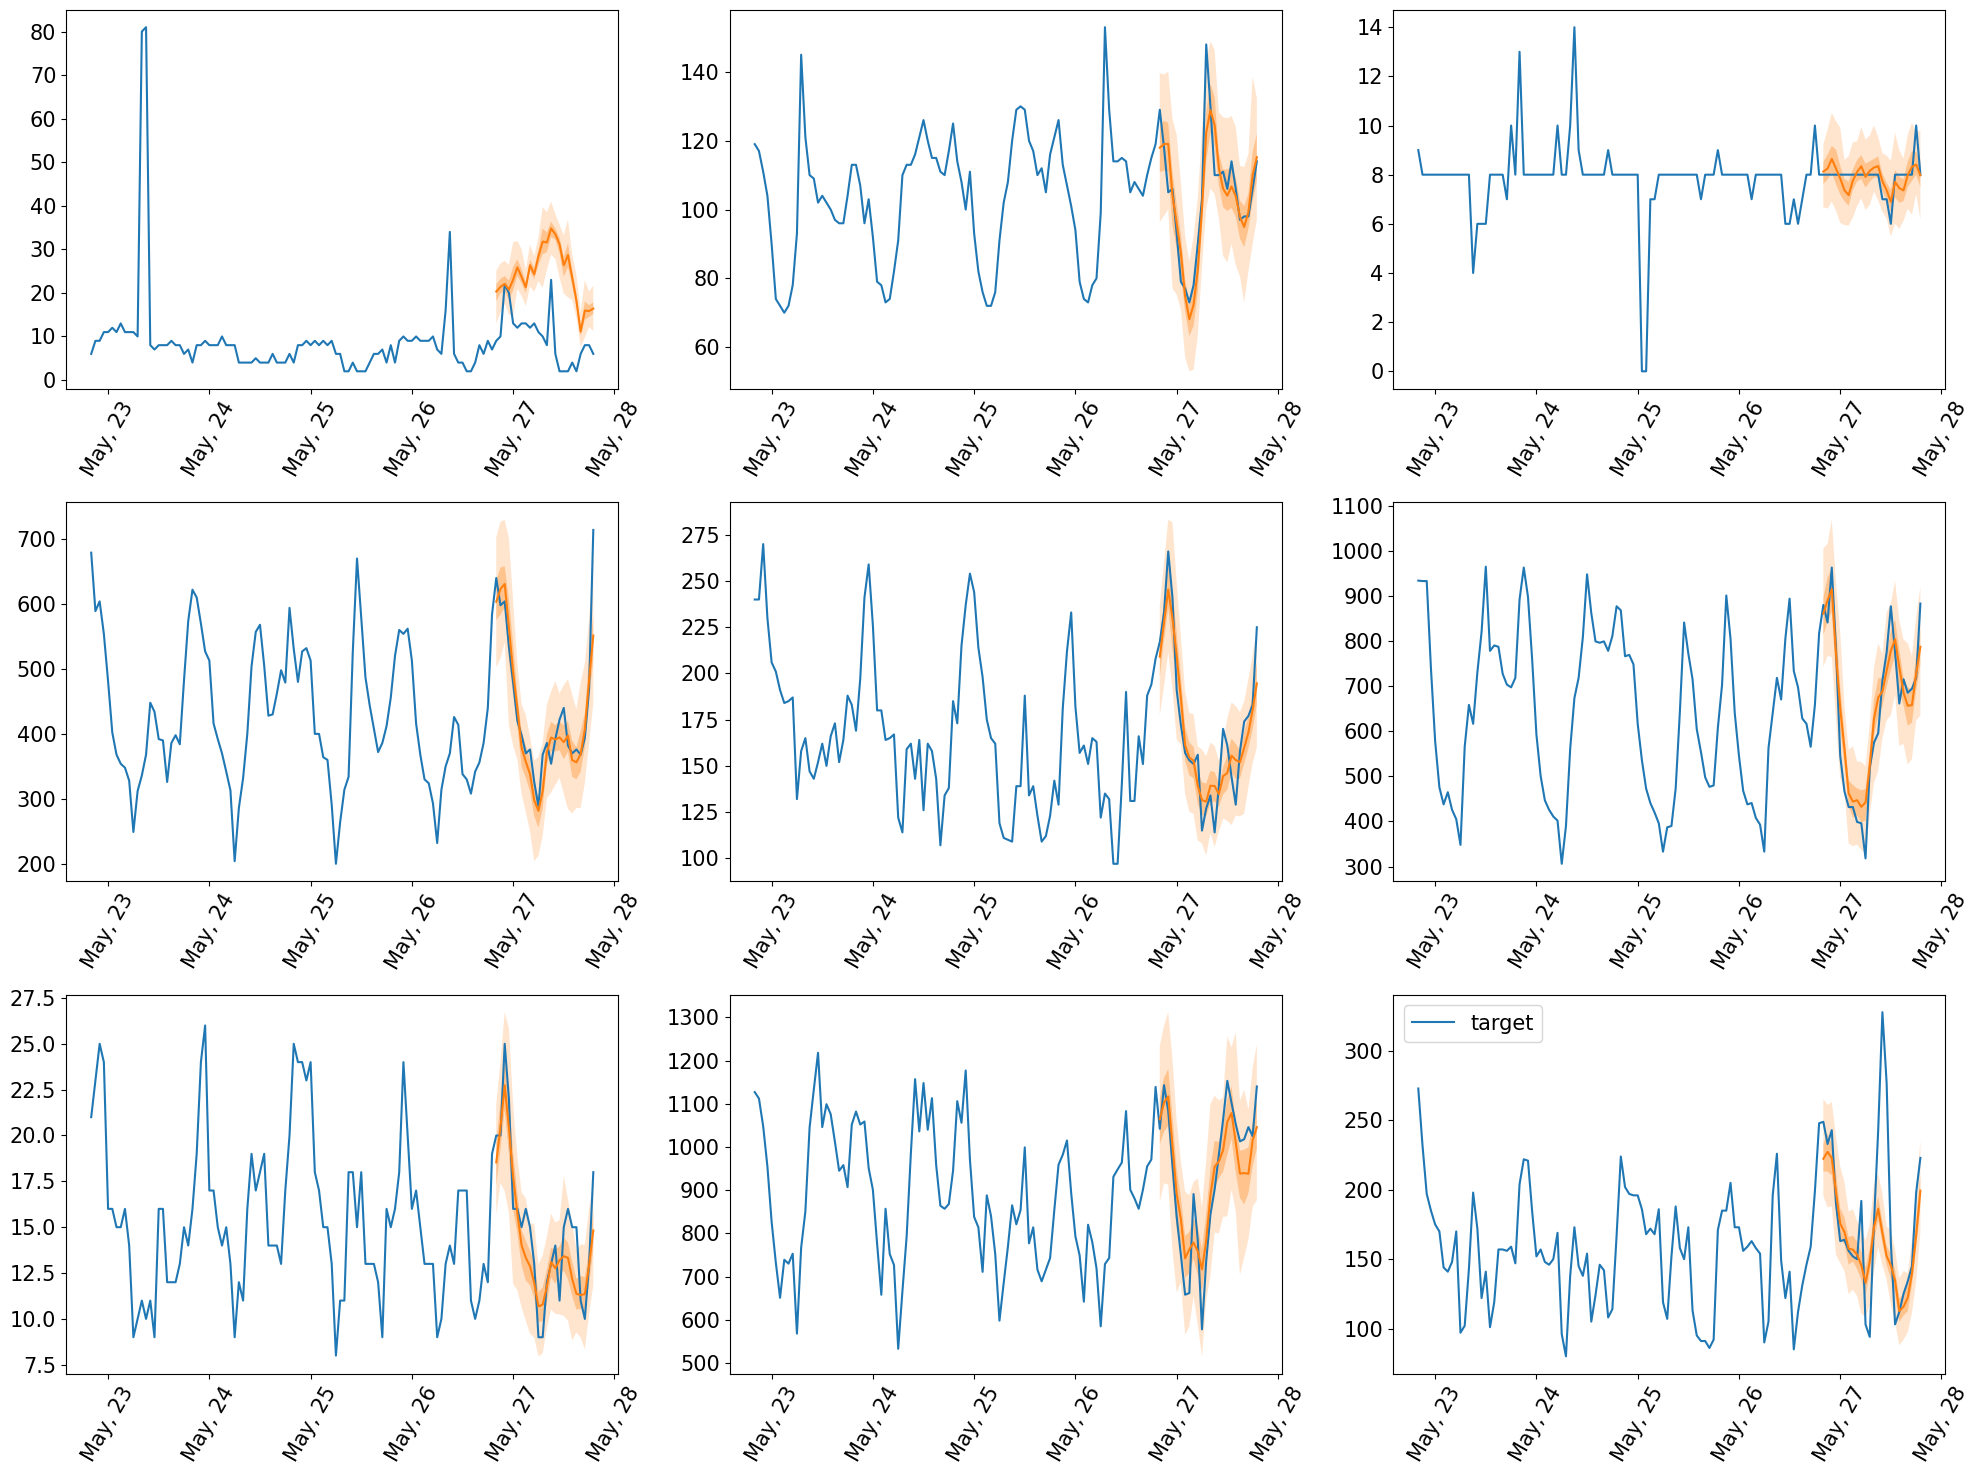

In [29]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.plot(ts[-5 * prediction_length :].to_timestamp(), label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

And we can compute evaluation metrics, that summarize the performance of the model on our test data.

In [30]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

In [31]:
metrics_pytorch, _ = evaluator(tss_pytorch, forecasts_pytorch)
pd.DataFrame.from_records(metrics_pytorch, index=["FeedForward"]).transpose()

Running evaluation: 2247it [00:06, 336.26it/s]
c:\Users\cesar\anaconda3\envs\gluon\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


,FeedForward
Coverage[0.1],1.331776e-01
Coverage[0.5],5.402945e-01
Coverage[0.9],8.979565e-01
MAE_Coverage,3.993188e-01
MAPE,1.565285e-01
MASE,1.002274e+00
MSE,3.607240e+06
MSIS,8.216852e+00
ND,9.493380e-02
NRMSE,7.962503e-01
